# Sentiment Analysis

1. Polarity of text: `pos`, `neg`, `neutral`
2. Aspect-based analysis: which particular aspects or features are mentioned in a positive, neutral, or negative way.

1. Overall sentiment
2. Sentiment by floor and space
3. Sentiment by type of space i.e. group vs individual
4. Sentiment by topic

In [1]:
import string

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import nltk
# import scipy.stats as ss

# nltk.download("stopwords")
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
drop_col_emo=['occupation', 'usage', 'recruitment', 'comfort']

# Students at LAB42

In [3]:
emo_sl42 = pd.read_csv('data/lab42_cleaned_data.csv', index_col=0).drop(columns = drop_col_emo, axis=1).dropna(subset=['emotion'])

In [4]:
emo_sl42.head()

,floor,ground-floor,1-floor,2-floor,3-floor,emotion
1,NaN,NaN,NaN,NaN,NaN,I always feel a bit zen when I am here. It’s q...
2,NaN,NaN,NaN,NaN,NaN,"Cold, a bit down"
3,NaN,NaN,NaN,NaN,NaN,Calm
4,6th Floor,NaN,NaN,NaN,NaN,"Hungry, a bit cold"
5,Ground floor,Library learning room,NaN,NaN,NaN,Stressed about my exams but I am happy in this...


## LLM-based Overall Sentiment Analysis

In [5]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def sentiment_analysis(sentence):
    return sentiment_task(sentence, top_k=3)

def assign_scores(idx):
    emo_sl42.at[idx, 'positive'] = next(item for item in emo_sl42['senti'][idx] if item['label'] == 'positive')['score']
    emo_sl42.at[idx, 'negative'] = next(item for item in emo_sl42['senti'][idx] if item['label'] == 'negative')['score']
    emo_sl42.at[idx, 'neutral'] = next(item for item in emo_sl42['senti'][idx] if item['label'] == 'neutral')['score']

def plot_sentiment_analysis(df, label):
    sns.countplot(y=df[label + "_label"], 
                  palette=['#b2d8d8',"#008080", '#db3d13'],
                  order=["positive", "negative", "neutral"])
    plt.ylabel("Overall Sentiment for Emotion Responses")
    plt.xlabel("Count")
    plt.savefig('plots/sentiment-analysis/students-lab42/' + label + '-llm-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')

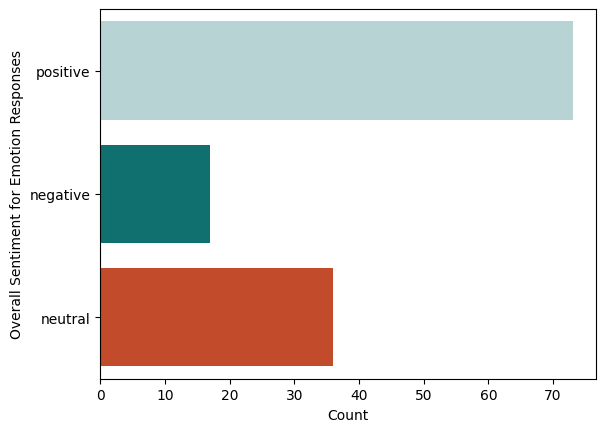

In [7]:
# 1. Calculate sentiment analysis on each emotion statement:
emo_sl42['senti'] = emo_sl42['emotion'].apply(sentiment_analysis)

# 2. Sort Sentiment Scores into Independent Columns
for idx in emo_sl42.index:
    assign_scores(idx)

# 3. Drop Unecessary Columns
emo_sl42 = emo_sl42.drop(columns=['senti'])

# 4. Calculate the dominant overall sentiment of the response
emo_sl42['emo_label'] = emo_sl42[['positive', 'negative', 'neutral']].idxmax(axis=1)

# 5. Plot the overall sentiments distribution
plot_sentiment_analysis(emo_sl42, 'emo')

## Lexicon-based Analysis using VADER
Here we are interested in the rule-based analysis. The compound score is computed by summing the 
valence scores of each word in the lexicon, adjusted according to the rules, and then normalized 
to be between -1 (most extreme negative) and +1 (most extreme positive). 
It is a 'normalized, weighted composite score.

In [8]:
def vader_lexicon_analysis(df, label):
    analyzer = SentimentIntensityAnalyzer()
    df[label + '-composite-score'] = df[label].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
    
    return df 

def plot_lexicon_analysis(df, label):
    sns.boxplot(x='floor', y='emotion-composite-score', data=df)
    plt.xlabel("Floor")
    plt.ylabel("Lexicon-based Normalised Weighted Composite Score \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/sentiment-analysis/students-lab42/' +
                label +
                '-vader-lexicon-composite.jpg',
                dpi=300,
                bbox_inches='tight')

    plt.clf()

    sns.displot(x='emotion-composite-score', kde=True, 
                height=4,
                aspect=1.5,
                data=emo_sl42)
    plt.xlabel("Lexicon-Based Normalised Weighted Composite Scores for Sentiments \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/sentiment-analysis/students-lab42/' +
                label +
                '-distribution-lexicon-composite.jpg',
                dpi=300,
                bbox_inches='tight')
    plt.clf()

    sns.displot(x='emotion-composite-score', y='emo_label',
                binwidth=(.2, .1),
                height=4,
                aspect=1.5,
                data=emo_sl42)
    plt.xlabel("Lexicon-Based Normalised Weighted Composite Scores for Sentiments \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.ylabel("LLM Generated Sentiment Labels")
    plt.tick_params(bottom=False)
    plt.savefig('plots/sentiment-analysis/students-lab42/' +
                label +
                '-vader-vs-lexicon-composite.jpg',
                dpi=300,
                bbox_inches='tight')

def plot_sentiment_analysis_spaces(df, label):
    df = df.where(df["space-type"] != "").dropna(how="all")
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='compound', width=0.5,
 data=df)
    plt.xlabel("Space Type")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/lab42-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

<Figure size 600x400 with 0 Axes>

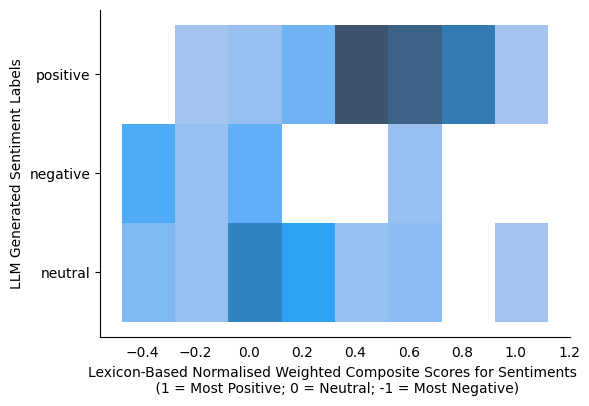

In [9]:
emo_sl42 = vader_lexicon_analysis(emo_sl42, 'emotion')
plot_lexicon_analysis(emo_sl42, 'emotion')

## Scale data to scores between -1 and 1
Polarity score in the range of -1 to -0.5 typically indicates negative sentiment
Polarity score greater than -0.5 and less than +0.5 typically indicates neutral sentiment
Polarity score in the range of +0.5 to 1 typically indicates positive sentiment

In [20]:
def scale_emotion_values():
    labels = ['positive', 'negative', 'neutral']
    scales = [(0.5, 1.0), (-1.0, -0.5), (-0.5, 0.5)]
    emo_sl42['scaled_scores'] = 0
    
    for label, scale in zip(labels, scales):
        values = np.array(emo_sl42[label][emo_sl42['emo_label'] == label]).reshape(-1,1)
        idx = emo_sl42.index[emo_sl42['emo_label'] == label].to_list()
        scaled_values = minmax_scaler(scale, values, idx)
        emo_sl42.loc[idx,'scaled_scores'] = scaled_values
    
    return emo_sl42


def minmax_scaler(scale, values, idx):
    scaler = MinMaxScaler(feature_range = scale)
    scaled_values = pd.Series(scaler.fit_transform(values).flatten()).set_axis(idx)
    
    return scaled_values 

In [21]:
emo_sl42 = scale_emotion_values()

In [30]:
group = ['Round tables by the three plants (across wooden staircase)',
                        'Next to the lockers',
                        'Study corner next to the plant wall',
                        'Yellow/white chairs & tables (besides the wooden staircase)',
                        'Tables on the landing (with wooden floor) accessible by the black staircase',
                        'Green group study tables (between a row of plants and railing)',
                        'Group tables by the stairs',
                        'Open lounge area',
                        'Near the printer',
                        'Round tables by the coffee machine']

individual =  ['Library learning room',
                             'Green chairs by the entrance',
                             'Partly covered green chairs (along glass wall)']

unsure = ["Unsure"]

def assign_types_to_spaces(space):
    if space in group:
        return "group"
    if space in individual:
        return "individual"
    if space in unsure:
        return "unsure"
    
def merge_spaces(df):
    df["space-type"] = df["space-ground-floor"] + df["space-1-floor"] + df["space-2-floor"] + df["space-3-floor"]
    df = df.drop(columns =["space-ground-floor", "space-1-floor", "space-2-floor", "space-3-floor"])
    
    return df


def create_group_solo_space_labels(df):
    spaces = ["ground-floor", "1-floor", "2-floor", "3-floor"]
    
    for space in spaces:
        df["space-" + space] = df[space].apply(lambda space: assign_types_to_spaces(space)).fillna("")
    
    return df


def plot_sentiment_analysis_spaces(df, label):
    df = df.where(df["space-type"] != "").dropna(how="all")
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='scaled_scores',
                width=0.5,
                data=df)
    plt.xlabel("Space Type")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/lab42-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')



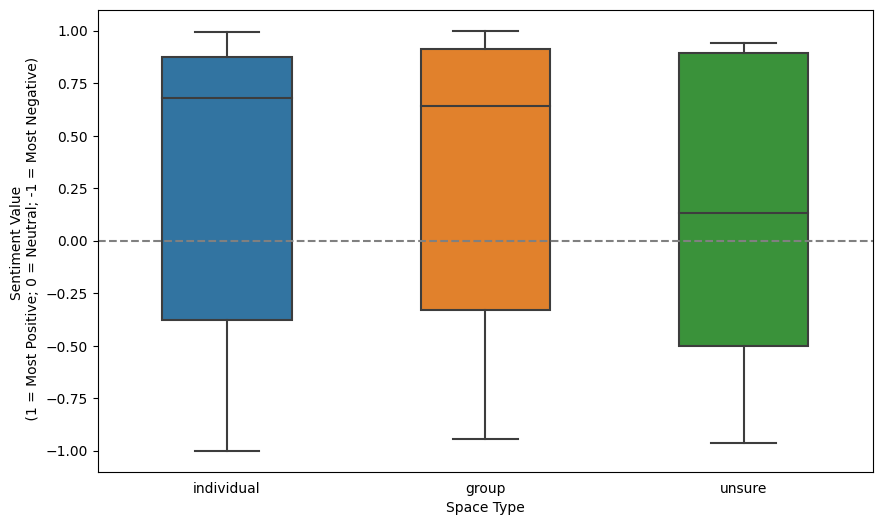

In [31]:
df = create_group_solo_space_labels(emo_sl42)
df = merge_spaces(df)
plot_sentiment_analysis_spaces(df, 'emotion')

In [60]:
def plot_overview_sentiment_analysis_spaces(df, label):
    df = df.where(df["space-type"] != "").dropna(how="all")
    f = plt.figure(figsize=(10, 6))
    sns.catplot(data=df, 
                x="floor", y='scaled_scores',
                hue="emo_label",
                col="space-type",
                kind="swarm" )
    plt.xlabel("Floor")
    plt.ylabel("Scaled Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.savefig('plots/lab42-' + label + 'floor-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')



# sns.countplot(y=emo_sl42["emo_label"], palette=['#b2d8d8',"#008080", '#db3d13'],order=["positive", "negative", "neutral"])

<Figure size 1000x600 with 0 Axes>

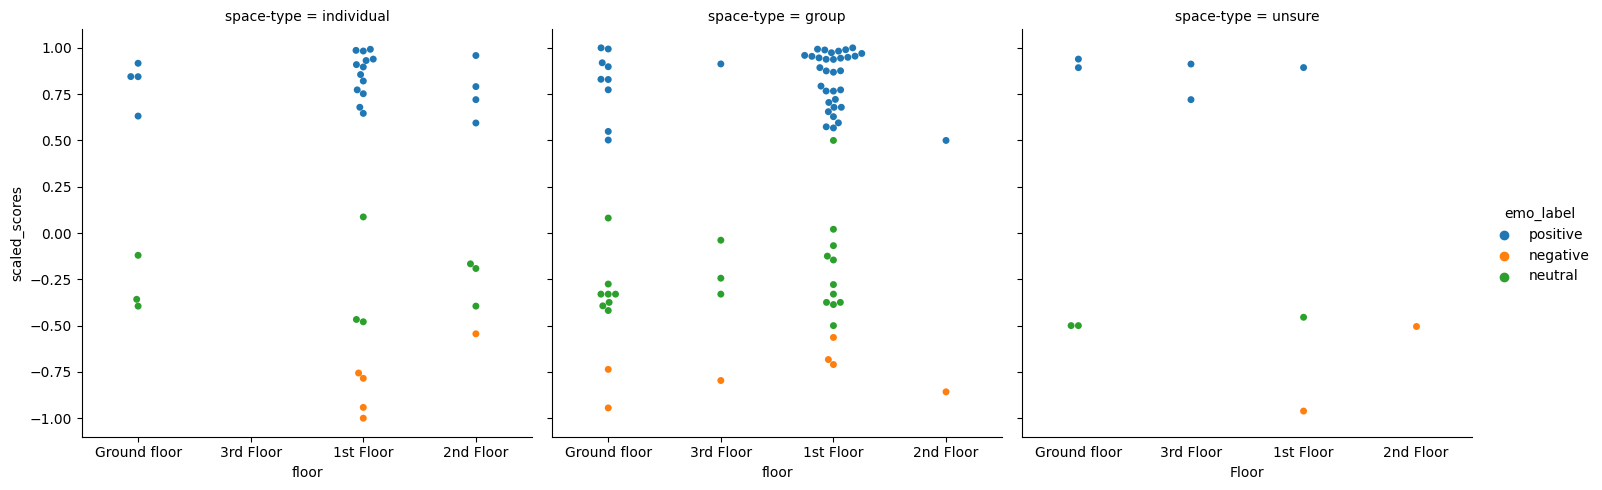

In [61]:
plot_overview_sentiment_analysis_spaces(emo_sl42, "emo")